In [131]:
# and testing set of X components
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [4]:
#import the files
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))

107

In [130]:
#this code creates blocks for time of the day after every 4hrs
#the analysis will be done every 4 hours
def blocks(data):
    hr_blocks=[]
    for i in np.array(data['time']):
        if i<4:
            hr_blocks.append(0)
        elif i<8:
            hr_blocks.append(1)
        elif i<12:
            hr_blocks.append(2)
        elif i<16:
            hr_blocks.append(3)
        elif i<20:
            hr_blocks.append(4)
        else:
            hr_blocks.append(5)
    data['time_blocks']=hr_blocks
    return data


In [72]:
#This function creates anew dataframe with the factors that are believed could distinguish between a risky event and 
# otherwise.
def preprocess_data(data):
    one=data
    #first create the timestamp and add month, daya, hour for purposes of grouping
    one['timestamp']=pd.to_datetime(one['timestamp'], format="%Y/%m/%d %H:%M:%S")
    
    one['month']=one['timestamp'].dt.month
    one['day']=one['timestamp'].dt.day
    one['time']=one['timestamp'].dt.hour
    #add the time blocks to the df
    one=blocks(one)

    #initialize the columsn to be dropped 
    # and drop them
    dr=["partition_date",'id',"coordinate_latitude","coordinate_longitude","vext","terminal_id","recieved_ts","gps_fix_type",
       "gps_accuracy","vgsm","MP_NAME","MN_NAME","DC_NAME","PR_NAME","created_ts","country_name"]
    one_1=one.drop(dr,axis=1)

    #copy the dataframe and drop all instances where the car had stopped 
    #i.e. not is motion , speed==0
    xx=one_1.copy()
    xx=xx[xx['speed'] != 0]

    #create the new df
    one_new=pd.DataFrame()
    #calculate the accel_Net_G
    Net_G=np.sqrt(xx['x_accel']**2+xx['y_accel']**2+xx['z_accel']**2)/9.81
    xx['Net_G']=Net_G
    xx['linear_g']=abs(xx['linear_g'])
    xx['lateral_g']=abs(xx['lateral_g'])
    ###start with the averages: averages are taken every 4hours
    columns=['speed','heading','Net_G','linear_g','lateral_g','altitude']
    aver=xx.groupby(['month','day','time_blocks'])[columns].mean() #averages of the columsn defined above

    one_new[columns]=aver[columns]
    #count of the number of suburbs cruised during the fours hours
    unique_sps=xx.groupby(['month','day','time_blocks'])[['SP_NAME']].count()
    one_new['sub_count']=unique_sps['SP_NAME']

    #odometer reading for the 4hour window
    no_km=xx.groupby(['month','day','time_blocks']).apply(lambda g: g.odometer.max()-g.odometer.min())
    one_new['KM_driven']=no_km

    #number of events per timeblock. unique events
    no_events=xx.groupby(['month','day','time_blocks'])['event_description'].nunique()
    one_new['No_events']=no_events

    #the driving above limit
    over_speeding=xx.groupby(['month','day','time_blocks'])['event_description'].agg(lambda s: pd.Series(['Speeding']).isin(s).any())
    one_new['Over_speeding']=over_speeding

    ##driving beyond road speed limit
    diff=xx['speed']-xx['road_speed']
    diff[diff<0]=np.nan
    #data[data == 0] = 
    #means = np.nanmean(data[:, 1:], axis=1)
    xx['magni_o_s']=diff/10
    one_new['ov_sp_mag']=xx.groupby(['month','day','time_blocks'])['magni_o_s'].mean()
    ##
    xx['beyond_r']=(xx['speed']>xx['road_speed']) & (xx['speed']<130)
    #number of instances the speed is above road limit
    one_new['above_limit']=xx.groupby(['month','day','time_blocks'])['beyond_r'].sum()

    ## total events such acceleration
    xx["corn_a_b"]=(xx['event_description']=='Cnr_brake') | (xx['event_description']=='Cnr_Accel')
    one_new['No_corner_b_a']=xx.groupby(['month','day','time_blocks'])['corn_a_b'].sum()

    #percentage of corners in speed above limit
    xx['Corner']=xx['event_description']=='Corner'
    #multiply with beyond speed
    xx['corner_ab_l']=xx['Corner']*xx['beyond_r']

    #get the average
    one_new['aver_corn']=xx.groupby(['month','day','time_blocks'])['corner_ab_l'].sum()
    #/xx.groupby(['month','day'])['Corner'].sum()

    ##drove at night? beyond 19 and before 5
    xx['night']=(xx['time']<=5) | (xx['time']>=19)
    one_new['night_drive']=xx.groupby(['month','day','time_blocks'])['night'].sum()

    one_new.reset_index(inplace=True)
    one_new=one_new.drop(['month','day','time_blocks'],axis=1)

    one_new=one_new.replace(np.nan,0)

    return one_new

In [117]:
#test the preprocessing with one dataframe
one_=pd.read_csv('169895882.csv')
one=preprocess_data(one_)

In [119]:
#perform PCA to identify the componentsin the new dataframe
pca1 = PCA(n_components = 2)
X_train_one = pca1.fit_transform(one)
explained_variance = pca1.explained_variance_ratio_

In [120]:
#the explained variance of the two components
explained_variance

array([9.99982331e-01, 1.70823975e-05])

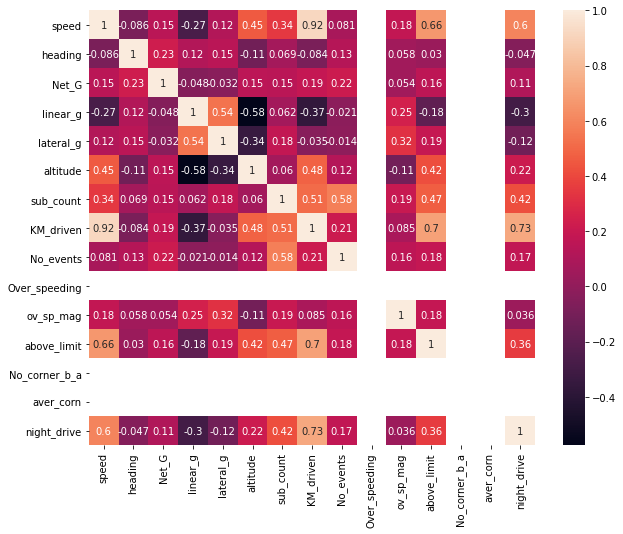

In [121]:
#plot the heatmap with correlations 
#this shows how features are correlated
plt.figure(figsize=(10,8))
sns.heatmap(one.corr(),annot=True)
plt.show()

In [122]:
#we cluster the principal components
#into to two clusters which might be used to identify the risk or no risk
Kmean1 = KMeans(n_clusters=2)
Kmean1.fit(X_train_one)

KMeans(n_clusters=2)

In [123]:
#centers for  KMenas
centers_one=Kmean1.cluster_centers_

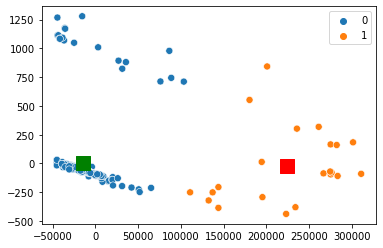

In [124]:
#plot a scatter plot of the  componenrs
#and their centers.
sns.scatterplot(x=X_train_one[ : , 0], y=X_train_one[ : , 1], s =50,hue=Kmean1.labels_)
plt.scatter( centers_one[0,0],  centers_one[0,1], s=200, c='g', marker='s')
plt.scatter(centers_one[1,0], centers_one[1,1], s=200, c='r', marker='s')
plt.show()

In [ ]:
# we choose the values that have a higher x axis values to be risk and hence we label 1 otherwise 0

In [128]:
#add the label column to the datasent
one['label']=Kmean1.labels_

In [ ]:
#from here we  need mass data preprocessing and saved them as either test or train

In [ ]:
#! this should be run first sample is random
### create a for loop that goes 
# import random
# files=set(random.sample(csv_files,60))
# full_set=set(csv_files)
# left=set(csv_files)-files

In [ ]:
files=list(files)
files.pop(8) #remove a data

In [ ]:
#explained_varaince
exp_val=[]
clusters=[]
for i in range(len(files)):
    data=pd.read_csv(files[i])
    if data.shape[0]<2000:
        pass
    else:
        dat=preprocess_data(data)
        pca= PCA(n_components = 2)
        dat_comp = pca.fit_transform(dat)
        exp_val.append(pca.explained_variance_ratio_)
        Kmean1 = KMeans(n_clusters=2)
        Kmean1.fit(dat_comp)
        centers=Kmean1.cluster_centers_
        labels_=Kmean1.labels_
        clusters.append(centers)
        if i==0:
            sns.scatterplot(x=dat_comp[ : , 0], y=dat_comp[ : , 1], s =50,hue=labels_)
            plt.scatter( centers[0,0],  centers[0,1], s=200, c='g', marker='s')
            plt.scatter(centers[1,0], centers[1,1], s=200, c='r', marker='s')
            plt.show()
        if labels_[np.argmax(dat_comp[ : , 0])]==1:
            dat['label']=labels_
        else:
             dat['label']=(~labels_.astype(bool)).astype(int)
        print(list(dat['label'])[np.argmax(dat_comp[ : , 0])]==1)
        file_name=files[i].split('/')[-1]
        dat.to_csv('training_data/'+file_name,index=None)

In [ ]:
#transform the files that were left out and save them in a test folder
left=list(left)
for i in range(len(left)):
    data=pd.read_csv(left[i])
    if data.shape[0]<2000:
        pass
    else:
        dat=preprocess_data(data)
    file_name=left[i].split('/')[-1]
    dat.to_csv('testing_data/'+file_name,index=None)
print('done')